# MMD tests in Julia

## Setup

In [1]:
using LinearAlgebra
using Statistics
using Plots    # Plots takes a long time to compile

# Parallel computing to speed up Bootstrap MMD. It still takes time though
using Distributed
rmprocs(procs()[2:end])
addprocs(8) # This should be the number of simultaneous processes your computer can do

include("MMD.jl")
include("IterativeMethods.jl")
include("Matrix2Tabular.jl")

include("kernel_setup_script.jl")


kernel_setup_script.jl has set up the interpolation problem. 
 Interpolation matrix is k_Z and the corresponding x axis is Z The right hand side is f_z. 
 The interpolation matrix for plotting is k_YZ and the corresponding x axis is Y. 
 The direct solution to k_Z \ f_z is X_direct_solution.

In [2]:
N = length(f_Z)
samples = 500;
iter = 3;
N_mmd_bootstrap = 1000;

### Normal distribution sampling function

In [3]:
function mv_normal(mean::Array{Float64,1},cov::Array{Float64,2},N_samples::Int64=1)
    M = length(mean)
    F = svd(cov)
    cov = F.V*(F.S.*F.V')
    samples = zeros(M,N_samples)
    for i = 1:N_samples
        samples[:,i] = mean + cov*randn(N)
    end
    return samples
end


mv_normal (generic function with 2 methods)

## Generating Samples

### Samples from $\mu_0$

In [4]:
input_samples = randn(N,samples);
guesses = randn(N,samples);

### Richardson

In [5]:
output_samples_R = zeros(N,samples)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    output_samples_R[:,i] = IterativeMethods.Richardson(k_Z,b,guesses[:,i],iter,IterativeMethods.Optimal)
end

### Jacobi

In [6]:
output_samples_J = zeros(N,samples)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    output_samples_J[:,i] = IterativeMethods.Jacobi(k_Z,b,guesses[:,i],iter,IterativeMethods.Optimal)
end

### Adaptive Richardson

In [7]:
output_samples_R_A = zeros(N,samples)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    output_samples_R_A[:,i] = IterativeMethods.Richardson(k_Z,b,guesses[:,i],iter,IterativeMethods.Adaptive)
end

### Second Order Richardson

In [8]:
output_samples_R_2 = zeros(N,samples)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    prior2 = IterativeMethods.Richardson(k_Z,f_Z,guesses[:,i],iter,IterativeMethods.Optimal)
    output_samples_R_2[:,i] = IterativeMethods.Richardson2(k_Z,b,[prior2; guesses[:,i]],iter)[1:N]
end

### CG

In [9]:
output_samples_CG = zeros(N,samples)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    output_samples_CG[:,i] = IterativeMethods.cg(k_Z,b,guesses[:,i],iter,1e-10)
end

### BayesCG

In [10]:
output_samples_BayesCG = zeros(N,samples)
inverse_prior = inv(k_Z)
for i = 1:samples
    xTrue = randn(N)
    b = k_Z*xTrue
    xm,sigm = IterativeMethods.bayescg(k_Z,b,guesses[:,i],inverse_prior,iter,1e-10)
    output_samples_R_A[:,i] = mv_normal(xm,sigm)
end

## MMD Tests

### Setup

In [11]:
results = zeros(3,6);

function run_mmd(input_samples,output_samples)
    ker = MMD.mmd_kernel_factory(input_samples,output_samples)
    mmd = MMD.mmd_p(input_samples,output_samples,ker)
    boot = MMD.bootstrap_mmd(input_samples[:,1:100],output_samples[:,1:100],ker,N_mmd_bootstrap)
    
    mmd_cdf = length(boot[boot.<=mmd])/length(boot)
    
    return mmd, mean(boot), mmd_cdf, boot
end

run_mmd (generic function with 1 method)

### Richardson, Jacobi, and Adaptive Richardson

In [12]:
# Richardson
results[1,1], results[2,1], results[3,1], boot_r = run_mmd(input_samples,output_samples_R);

# Jacobi
results[1,2], results[2,2], results[3,2], boot_j = run_mmd(input_samples,output_samples_J);

# Adaptive
results[1,3], results[2,3], results[3,3], boot_ar = run_mmd(input_samples,output_samples_R_A);

### Second Order, CG, and BayesCG

In [13]:
# Second Order
results[1,4], results[2,4], results[3,4], boot_r2 = run_mmd(input_samples,output_samples_R_2);

# CG
results[1,5], results[2,5], results[3,5], boot_cg = run_mmd(input_samples,output_samples_CG);

# BayesCG
results[1,6], results[2,6], results[3,6], boot_bayescg = run_mmd(input_samples,output_samples_BayesCG);

### Table of Results

In [37]:
# Converts matrix to LaTeX tabular in scienfitic notation

figs = 2  #Number of figures after the decimal
dollars = true  # Whether to have dollar signs for LaTeX. true for tables, false for matrices.

print(Matrix2Tabular.matrix2tabular(results,figs,dollars))

  $6.24\times 10^{-4}$  $5.99\times 10^{-4}$  $9.71\times 10^{-2}$  $3.28\times 10^{-2}$  $2.05\times 10^{-4}$  $2.47\times 10^{-1}$ \\ 
  $-1.43\times 10^{-5}$  $1.33\times 10^{-6}$  $5.02\times 10^{-5}$  $-3.5\times 10^{-7}$  $-1.36\times 10^{-5}$  $2.33\times 10^{-5}$ \\ 
  $9.3\times 10^{-1}$  $9.16\times 10^{-1}$  $1.0$  $1.0$  $7.11\times 10^{-1}$  $1.0$ \\ 
 

### Plots of Results

#### Richardson Bootstrap MMD Compared to MMD

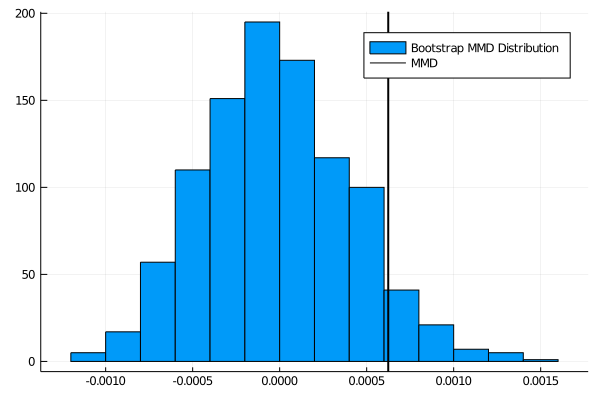

In [51]:
histogram(boot_r, label="Bootstrap MMD Distribution")
vline!([results[1,1]], linewidth=2, linecolor="black", label="MMD")


#### Richardson compared to 1-$\alpha$

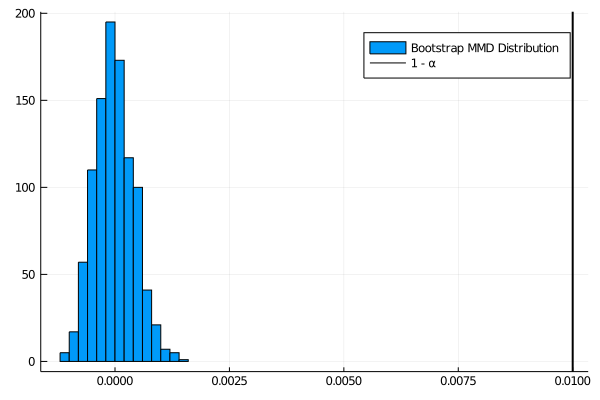

In [50]:
α = .99
histogram(boot_r, label="Bootstrap MMD Distribution")
vline!([1-α], linewidth=2, linecolor="black", label="1 - α")

#### BayesCG Bootstrap MMD Compared to MMD

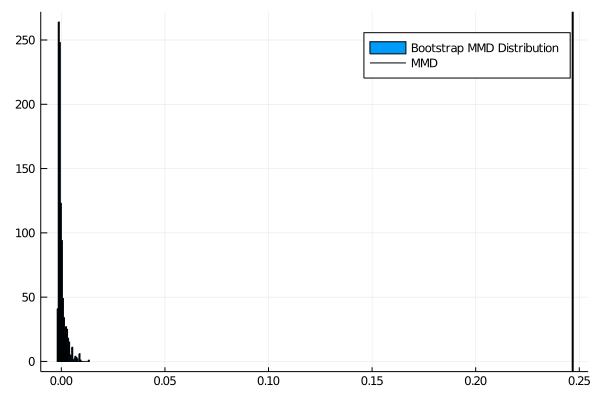

In [48]:
histogram(boot_bayescg, label="Bootstrap MMD Distribution")
vline!([results[1,6]], linewidth=2, linecolor="black", label="MMD")


#### BayesCG Bootstrap MMD compared to 1-$\alpha$

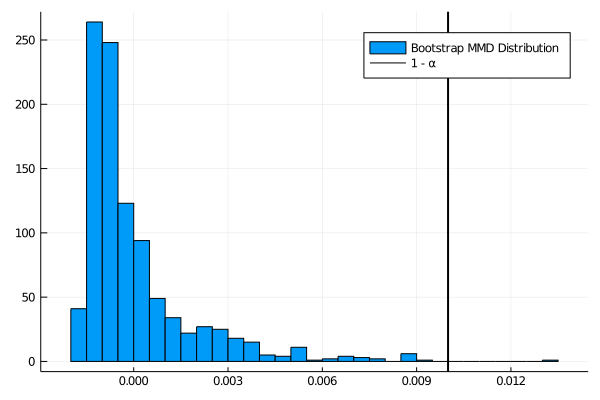

In [49]:
α = 0.99
histogram(boot_bayescg, label="Bootstrap MMD Distribution")
vline!([1-α], linewidth=2, linecolor="black", label="1 - α")
